In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score,confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SequentialFeatureSelector

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

/Users/natalie/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [7]:
test = pd.read_parquet('/Users/natalie/Desktop/DS Thesis/Code/data/test.parquet')
train = pd.read_parquet('/Users/natalie/Desktop/DS Thesis/Code/data/train.parquet')

In [2]:
TARGET ='churn_user'
CATEGORICAL_FEATURES  = ['os_name', 'age_group','gender', 'country', 'region', 'province_type',
                         'province']
DATETIME_FEATURES  = ['first_date', 'lastest_active_day']
SEARCH_CC_FEATURES = [ 'clicks', 'search_volume', 'dating_search', 'videoclip_search', 'technical_search', 'housekeeping_family_search', 'marketing_search', 'other_search']
SEARCH_GG_FEATURES = [ 'serp_click', 'search_volume_gg', 'search_clicks_gg', 'other_search_gg','housekeeping_family_search_gg','videoclip_search_gg', 'dating_search_gg', 'marketing_search_gg', 'technical_search_gg']
ACTIVE_FEATURES = ['active_day', 'life_time',  'not_active_day', 'total_active_time']
ADS_FEATURES =  ['ads_impression', 'ads_click', 'ads_revenue']
OTHERS_FEATURES =[                      'newtab_count', 'download_count', 'pip_count', 'sidebar_count', 'incognito_count', 'signin_count', 'youtube_count',
                    'work_count', 'social_count', 'news_count', 'entertainment_count', 'ecommerce_count']
NUMERICAL_FEATURES = SEARCH_CC_FEATURES + SEARCH_GG_FEATURES + ACTIVE_FEATURES + ADS_FEATURES + OTHERS_FEATURES

MODEL_NAMES = ['log_reg', 'randomforest','lightgbm', 'xgboost', 'mlp']


In [3]:
def find_best_threshold_f1_score(train_labels, oofs, average='macro'):
    scores = []
    thresholds = []
    best_score = 0
    best_threshold = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        print(f'{threshold:.02f}, ', end='')
        preds = (oofs > threshold).astype('int')
        m = f1_score(train_labels, preds, average=average)
        scores.append(m)
        thresholds.append(threshold)
        if m > best_score:
            best_score = m
            best_threshold = threshold
    return best_threshold, best_score


In [4]:
def fillna(df):
    df['total_active_time'] = df['total_active_time'].fillna(0)
    df['ads_impression'] = df['ads_impression'].fillna(0)
    df['ads_click'] = df['ads_click'].fillna(0)
    df['ads_revenue'] = df['ads_revenue'].fillna(0)
    df['clicks'] = df['clicks'].fillna(0)
    for c in OTHERS_FEATURES:
        df[c] = df[c].fillna(0)
    return df

def process_data(df,oh_encoder=None, robust_scaler=None,agg_features=None):
    if not oh_encoder:
        print("fit train OneHotEncoder")
        oh_encoder = OneHotEncoder()
        oh_encoder.fit(df[CATEGORICAL_FEATURES])
    else:
        print("loadd onehot encoder")
    if not robust_scaler:
        print("fit train RobustScaler")
        robust_scaler = RobustScaler()
        robust_scaler.fit(df[NUMERICAL_FEATURES])
    else:
        print("loadd robust scaler")
    df_cat = pd.DataFrame(oh_encoder.transform(df[CATEGORICAL_FEATURES]).toarray())
    new_cat_cols = oh_encoder.get_feature_names_out(CATEGORICAL_FEATURES)
    df_cat.columns = new_cat_cols
    df_num = pd.DataFrame(robust_scaler.transform(df[NUMERICAL_FEATURES]))
    df_num.columns = NUMERICAL_FEATURES
    new_df = pd.concat([df_cat.reset_index(drop=True), df_num.reset_index(drop=True)], axis=1)
    new_df = fillna(new_df)
    return new_df, oh_encoder, robust_scaler

In [5]:
N_ESTIMATORS = 200
SEED=42

RF_Hyperparameters = {
    'n_estimators': N_ESTIMATORS,
    'max_depth':8,
    'random_state':SEED,
    'max_features': 'sqrt', 
    'n_jobs': -1
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
models = []
def cross_validate_get_feature_importance(train,FEATURES=None,USE_SMOTE=False, USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    oofs = np.zeros((train.shape[0], len(MODEL_NAMES)))
    for i, (train_index, valid_index) in enumerate(kfold.split(train, train[TARGET])):
        print(f"===========fold {i}================")
        X_train, oh_encoder, robust_scaler = process_data(train.iloc[train_index])
        X_valid, _, _  = process_data(train.iloc[valid_index], oh_encoder,robust_scaler)
        if FEATURES is not None:
            X_train = X_train[FEATURES]
            X_valid = X_valid[FEATURES]
        print(X_train.isnull().sum())
        y_train = train.iloc[train_index][TARGET].values
        y_valid = train.iloc[valid_index][TARGET].values
        rf_hyperparameters = RF_Hyperparameters.copy()
        if USE_SMOTE:
            print("SMOTEEEE")
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
        elif USE_CLASS_WEIGHT:
            print("CLASS_WEIGHTTTT")
           
            class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
            class_weights =  {0: class_weights[0], 1: class_weights[1]}
            rf_hyperparameters['class_weight'] = class_weights
        elif USE_UNDER_SAMPLING:
            print("UNDER SAMPLING")
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
        print("Random Forest--------------")
        rf_model = RandomForestClassifier(**rf_hyperparameters)
        rf_model.fit(X_train, y_train)
        rf_y_pred_proba = rf_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, rf_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in rf_y_pred_proba]

        print(roc_auc_score(y_valid, rf_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,1] = rf_y_pred_proba
        models.append(rf_model)
        
    return oofs, models

In [8]:
X_train,oh_encoder,robust_scaler = process_data(train)
X_test, _,_ = process_data(test,oh_encoder,robust_scaler)
y_train = train[TARGET].values
y_test = test[TARGET].values

fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler


In [9]:
# Drops 64 dummy varialbes related to Provice
drop_X_train = [x for x in X_train.columns if 'province' not in x and x!='churn_user']

In [26]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

Logreg_Hyperparameters = {'max_iter':1,'random_state':42} 

lr_model = LogisticRegression(**Logreg_Hyperparameters)
for i in [20,30,40,50,100]:
    sfs = SequentialFeatureSelector(lr_model, n_features_to_select=i, direction="backward", n_jobs=1)
    sfs.fit(X_train[drop_X_train], y_train)
    print(sfs.get_feature_names_out())

['os_name_windows' 'age_group_18-24' 'age_group_25-34' 'age_group_unknown'
 'gender_female' 'gender_male' 'gender_unknown' 'clicks' 'other_search'
 'active_day' 'life_time' 'not_active_day' 'total_active_time'
 'ads_impression' 'ads_revenue' 'newtab_count' 'signin_count' 'work_count'
 'social_count' 'news_count']
['os_name_macos' 'os_name_windows' 'age_group_15-17' 'age_group_18-24'
 'age_group_25-34' 'age_group_35-44' 'age_group_45-54' 'age_group_55+'
 'age_group_under 14' 'age_group_unknown' 'gender_female' 'gender_male'
 'gender_unknown' 'country_UNKNOWN' 'clicks' 'other_search' 'active_day'
 'life_time' 'not_active_day' 'total_active_time' 'ads_impression'
 'ads_revenue' 'newtab_count' 'signin_count' 'youtube_count' 'work_count'
 'social_count' 'news_count' 'entertainment_count' 'ecommerce_count']
['os_name_macos' 'os_name_windows' 'age_group_15-17' 'age_group_18-24'
 'age_group_25-34' 'age_group_35-44' 'age_group_45-54' 'age_group_55+'
 'age_group_under 14' 'age_group_unknown' 'ge

ValueError: n_features_to_select must be < n_features.

In [27]:
N_ESTIMATORS = 200
SEED=42
LGBM_Hyperparameters =  {
    "n_estimators": N_ESTIMATORS,
    'learning_rate':0.03,
     'max_depth':8,
     'colsample_bytree':0.8,
     'subsample':0.8,
     # 'reg_alpha':8,
     # 'reg_lambda':32,

    "random_state":SEED,
    'device':'gpu',
#     "class_weight": "balanced"
}

XGBoost_Hyperparameters = {
    'objective' : 'binary:logistic',
     'eval_metric':['logloss', 'auc'],
     'n_estimators':N_ESTIMATORS,
     'learning_rate':0.03,
     'max_depth':8,
     'colsample_bytree':0.5,
     'subsample':0.8,
     'reg_alpha':8,
     'reg_lambda':32,
     'seed':SEED,
     # 'scale_pos_weight':3,
     'enable_categorical':True,
     'early_stopping_rounds': 50,
     'tree_method':'gpu_hist'}
RF_Hyperparameters = {
    'n_estimators': N_ESTIMATORS,
    'max_depth':8,
    'random_state':SEED,
    'max_features': 'sqrt', 
    'n_jobs': -1
}
Logreg_Hyperparameters = {'max_iter':N_ESTIMATORS,'random_state':SEED} 
MLP_Hyperparametesr = {'hidden_layer_sizes':(3,125), 'random_state':SEED, 'max_iter':min(N_ESTIMATORS,100)}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

def cross_validate(train, FEATURES=None, USE_SMOTE=False, USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    oofs = np.zeros((train.shape[0], len(MODEL_NAMES)))
    for i, (train_index, valid_index) in enumerate(kfold.split(train, train[TARGET])):
        print(f"===========fold {i}================")
        X_train, oh_encoder, robust_scaler = process_data(train.iloc[train_index])
        X_valid, _, _  = process_data(train.iloc[valid_index], oh_encoder,robust_scaler)
        if FEATURES is not None:
            print("Number of features", len(FEATURES))
            X_train = X_train[FEATURES]
            X_valid = X_valid[FEATURES]
        print(X_train.isnull().sum())
        y_train = train.iloc[train_index][TARGET].values
        y_valid = train.iloc[valid_index][TARGET].values
        logreg_hyperparameters = Logreg_Hyperparameters.copy()
        lgb_hyperparameters = LGBM_Hyperparameters.copy()
        xgboost_hyperparameters = XGBoost_Hyperparameters.copy()
        rf_hyperparameters = RF_Hyperparameters.copy()
        mlp_hyperparameters = MLP_Hyperparametesr.copy()
        if USE_SMOTE:
            print("SMOTEEEE")
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
        elif USE_CLASS_WEIGHT:
            print("CLASS_WEIGHTTTT")
           
            class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
            class_weights =  {0: class_weights[0], 1: class_weights[1]}
            lgb_hyperparameters['class_weight'] = class_weights
            logreg_hyperparameters['class_weight'] = class_weights
            xgboost_hyperparameters['scale_pos_weight'] = class_weights[1] /  class_weights[0]
            rf_hyperparameters['class_weight'] = class_weights
        elif USE_UNDER_SAMPLING:
            print("UNDER SAMPLING")
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
        print("LOGREG--------------")
        logreg_model = LogisticRegression(**logreg_hyperparameters)
        logreg_model.fit(X_train, y_train)
        logreg_y_pred_proba = logreg_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, logreg_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in logreg_y_pred_proba]

        print(roc_auc_score(y_valid, logreg_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,0] = logreg_y_pred_proba

        print("Random Forest--------------")
        rf_model = RandomForestClassifier(**rf_hyperparameters)
        rf_model.fit(X_train, y_train)
        rf_y_pred_proba = rf_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, rf_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in rf_y_pred_proba]

        print(roc_auc_score(y_valid, rf_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,1] = rf_y_pred_proba
    #     models.append(model)
        print("LGBModel--------------")
        lgb_model = LGBMClassifier(**lgb_hyperparameters)
        callbacks = [lgb.early_stopping(200, verbose=50), lgb.log_evaluation(period=50)]
        lgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric=["logloss", "auc"],
                  callbacks=callbacks)

        lgb_y_pred_proba = lgb_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, lgb_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in lgb_y_pred_proba]
        print(roc_auc_score(y_valid, lgb_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,2] = lgb_y_pred_proba
    #     models.append(model)
        # display(pd.DataFrame({'score': lgb_model.feature_importances_, 'feature': lgb_model.feature_name_}).sort_values('score',ascending=False))

        print("XGBoost--------------")
        xgb_model = XGBClassifier(**xgboost_hyperparameters)
        xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=50)
        xgb_y_pred_proba = xgb_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, xgb_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in xgb_y_pred_proba]
        print(roc_auc_score(y_valid, xgb_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index, 3] = xgb_y_pred_proba
        
        print("MLP------------------")
        mlp_model = MLPClassifier(**mlp_hyperparameters)
        mlp_model.fit(X_train, y_train)
        mlp_y_pred_proba = mlp_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, mlp_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in mlp_y_pred_proba]
        print(roc_auc_score(y_valid, mlp_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index, 4] = mlp_y_pred_proba
    return oofs

In [28]:
accuracy_scores = []
f1_scores = []
auc_scores = []
specificity_scores = []
sensitivity_scores = []
def scoring(y_test,y_pred_proba, best_threshold):
    y_pred = [1 if y_hat >= best_threshold else 0 for y_hat in y_pred_proba]
    acc = accuracy_score(y_test, y_pred)
    _f1_score = f1_score(y_test, y_pred, average='macro')
    auc_score = roc_auc_score(y_test, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    print("accuracy", acc)
    print("f1_score", _f1_score)
    print("auc", auc_score)
    print("sensitivity", sensitivity, "specificity", specificity)
    print(classification_report(y_test, y_pred, digits=4))
    return acc, _f1_score, auc_score, specificity, sensitivity

In [29]:
def train_model(oofs,X_train, y_train, X_test, y_test, USE_SMOTE=False,USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    models = []
    predictions = []
    accuracy_scores = []
    f1_scores = []
    auc_scores = []
    specificity_scores = []
    sensitivity_scores = []
    best_thresholds = []
    for i in range(len(MODEL_NAMES)):
        best_threshold, best_score = find_best_threshold_f1_score(train[TARGET].values, oofs[:,i])
        best_thresholds.append(best_threshold)
        print('\n',best_threshold, best_score)
    logreg_hyperparameters = Logreg_Hyperparameters.copy()
    lgb_hyperparameters = LGBM_Hyperparameters.copy()
    xgboost_hyperparameters = XGBoost_Hyperparameters.copy()
    del xgboost_hyperparameters['early_stopping_rounds']
    rf_hyperparameters = RF_Hyperparameters.copy()
    mlp_hyperparameters = MLP_Hyperparametesr.copy()
    if USE_SMOTE:
        print("SMOTEEEE")
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    elif USE_CLASS_WEIGHT:
        print("CLASS_WEIGHTTTT")
        class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        class_weights =  {0: class_weights[0], 1: class_weights[1]}
        lgb_hyperparameters['class_weight'] = class_weights
        logreg_hyperparameters['class_weight'] = class_weights
        xgboost_hyperparameters['scale_pos_weight'] = class_weights[1]/ class_weights[0]
        rf_hyperparameters['class_weight'] = class_weights
    elif USE_UNDER_SAMPLING:
        print("UNDER SAMPLING")
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)

    print("LOGREG--------------")
    logreg_model = LogisticRegression(**logreg_hyperparameters)
    logreg_model.fit(X_train, y_train)
    logreg_y_pred_proba = logreg_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,logreg_y_pred_proba,best_thresholds[0])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(logreg_y_pred_proba)
    models.append(logreg_model)

    print("Random Forest--------------")
    rf_model = RandomForestClassifier(**rf_hyperparameters)
    rf_model.fit(X_train, y_train)
    rf_y_pred_proba = rf_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,rf_y_pred_proba,best_thresholds[1])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(rf_y_pred_proba)
    models.append(rf_model)

    print("LGBModel--------------")
    lgb_model = LGBMClassifier(**lgb_hyperparameters)
    lgb_model.fit(X_train, y_train)
    lgb_y_pred_proba = lgb_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,lgb_y_pred_proba,best_thresholds[2])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(lgb_y_pred_proba)
    models.append(lgb_model)

    print("XGBoost--------------")
    print(xgboost_hyperparameters)
    xgb_model = XGBClassifier(**xgboost_hyperparameters)
    xgb_model.fit(X_train, y_train)
    xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,xgb_y_pred_proba,best_thresholds[3])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(xgb_y_pred_proba)
    models.append(xgb_model)
    
    print("MLP--------------")
    mlp_model = MLPClassifier(**mlp_hyperparameters)
    mlp_model.fit(X_train, y_train)
    mlp_y_pred_proba = mlp_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,mlp_y_pred_proba,best_thresholds[4])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(mlp_y_pred_proba)
    models.append(mlp_model)

    print(MODEL_NAMES)
    print(accuracy_scores)
    print(f1_scores)
    print(auc_scores)
    print(specificity_scores)
    print(sensitivity_scores)
    score_df = pd.DataFrame({'model_name': MODEL_NAMES,
                         'accuracy_score':accuracy_scores, 
                         'f1_score': f1_scores, 
                         'auc_score': auc_scores, 
                         'specificity_score': specificity_scores, 
                         'sensitivity_score': sensitivity_scores})
    return score_df,models, predictions

In [30]:
X_train,oh_encoder,robust_scaler = process_data(train)
X_test, _,_ = process_data(test,oh_encoder,robust_scaler)
y_train = train[TARGET].values
y_test = test[TARGET].values

fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler


In [29]:
nothing_oofs = cross_validate(train,FEATURES=top_features[:10])
nothing_score_df, nothing_models, nothing_predictions = train_model(nothing_oofs,X_train[top_features[:10]], y_train, X_test[top_features[:10]], y_test)

===========fold 0================
fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler
Number of features 10
active_day           0
not_active_day       0
age_group_unknown    0
gender_unknown       0
signin_count         0
ads_impression       0
newtab_count         0
clicks               0
life_time            0
ads_revenue          0
dtype: int64
LOGREG--------------
0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
 best_threshold 0.4099999999999998 best_score 0.7627059253434628
0.8785248572082487
              precision    

In [34]:
top_features = [['os_name_windows', 'gender_female', 'clicks', 'other_search',
       'active_day', 'not_active_day', 'total_active_time',
       'ads_impression', 'newtab_count', 'signin_count'],
       ['os_name_windows', 'age_group_18-24', 'age_group_25-34', 'age_group_unknown',
 'gender_female', 'gender_male', 'gender_unknown', 'clicks', 'other_search',
 'active_day', 'life_time', 'not_active_day', 'total_active_time',
 'ads_impression', 'ads_revenue', 'newtab_count', 'signin_count', 'work_count',
 'social_count', 'news_count'],
 ['os_name_macos', 'os_name_windows', 'age_group_15-17', 'age_group_18-24',
 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55+',
 'age_group_under 14', 'age_group_unknown', 'gender_female', 'gender_male',
 'gender_unknown', 'country_UNKNOWN', 'clicks', 'other_search', 'active_day',
 'life_time', 'not_active_day', 'total_active_time', 'ads_impression',
 'ads_revenue', 'newtab_count', 'signin_count', 'youtube_count', 'work_count',
 'social_count', 'news_count', 'entertainment_count', 'ecommerce_count'],
 ['os_name_macos', 'os_name_windows', 'age_group_15-17', 'age_group_18-24',
 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55+',
 'age_group_under 14', 'age_group_unknown', 'gender_female', 'gender_male',
 'gender_unknown', 'country_IN', 'country_UNKNOWN', 'region_Central Vietnam',
 'region_Northern Vietnam', 'region_Southern Vietnam', 'region_None',
 'clicks', 'other_search', 'serp_click', 'search_volume_gg',
 'marketing_search_gg', 'active_day', 'life_time', 'not_active_day',
 'total_active_time', 'ads_impression', 'ads_click', 'ads_revenue',
 'newtab_count', 'pip_count', 'signin_count', 'youtube_count', 'work_count',
 'social_count', 'news_count', 'entertainment_count', 'ecommerce_count'], 
 ['os_name_macos', 'os_name_windows', 'age_group_15-17', 'age_group_18-24',
 'age_group_25-34', 'age_group_35-44', 'age_group_45-54', 'age_group_55+',
 'age_group_under 14', 'age_group_unknown', 'gender_female', 'gender_male',
 'gender_unknown', 'country_IN', 'country_UNKNOWN', 'region_Central Vietnam',
 'region_Northern Vietnam', 'region_Southern Vietnam', 'region_None',
 'clicks', 'search_volume', 'dating_search', 'housekeeping_family_search',
 'other_search', 'serp_click', 'search_volume_gg', 'search_clicks_gg',
 'other_search_gg', 'housekeeping_family_search_gg', 'dating_search_gg',
 'marketing_search_gg', 'technical_search_gg', 'active_day', 'life_time',
 'not_active_day', 'total_active_time', 'ads_impression', 'ads_click',
 'ads_revenue', 'newtab_count', 'download_count', 'pip_count',
 'incognito_count', 'signin_count', 'youtube_count', 'work_count',
 'social_count', 'news_count', 'entertainment_count', 'ecommerce_count']]

for features in top_features[1:]:
    print(features, len(features))
    nothing_oofs_ = cross_validate(train,FEATURES=features)
    nothing_score_df_, nothing_models_, nothing_predictions_ = train_model(nothing_oofs_,X_train[features], y_train, X_test[features], y_test)
    nothing_score_dfs.append(nothing_score_df_)

['os_name_windows', 'age_group_18-24', 'age_group_25-34', 'age_group_unknown', 'gender_female', 'gender_male', 'gender_unknown', 'clicks', 'other_search', 'active_day', 'life_time', 'not_active_day', 'total_active_time', 'ads_impression', 'ads_revenue', 'newtab_count', 'signin_count', 'work_count', 'social_count', 'news_count'] 20
===========fold 0================
fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler
Number of features 20
os_name_windows      0
age_group_18-24      0
age_group_25-34      0
age_group_unknown    0
gender_female        0
gender_male          0
gender_unknown       0
clicks               0
other_search         0
active_day           0
life_time            0
not_active_day       0
total_active_time    0
ads_impression       0
ads_revenue          0
newtab_count         0
signin_count         0
work_count           0
social_count         0
news_count           0
dtype: int64
LOGREG--------------
0.10, 0.11, 0.12, 0.13, 0.14,

In [37]:
a = nothing_score_dfs.copy()

In [38]:
for i, n_features in enumerate([10,20,30,40,50]):
    a[i]['n_features'] = str(n_features)

In [43]:
outputs= pd.concat(a)


In [40]:
pd.concat(a).to_excel('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/backward_feature_selection.xlsx', index=False)

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

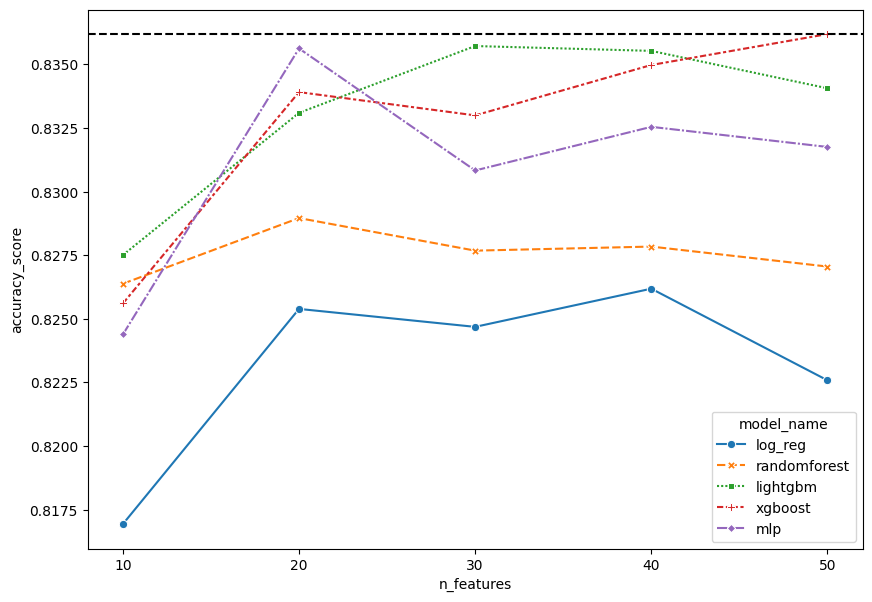

In [44]:
plt.figure(figsize=(10,7))
sns.lineplot(x='n_features', y='accuracy_score',data=outputs, hue='model_name',style='model_name', markers=True,dashes=True)
plt.axhline(t['accuracy_score'].max(), linestyle='--',color='black')

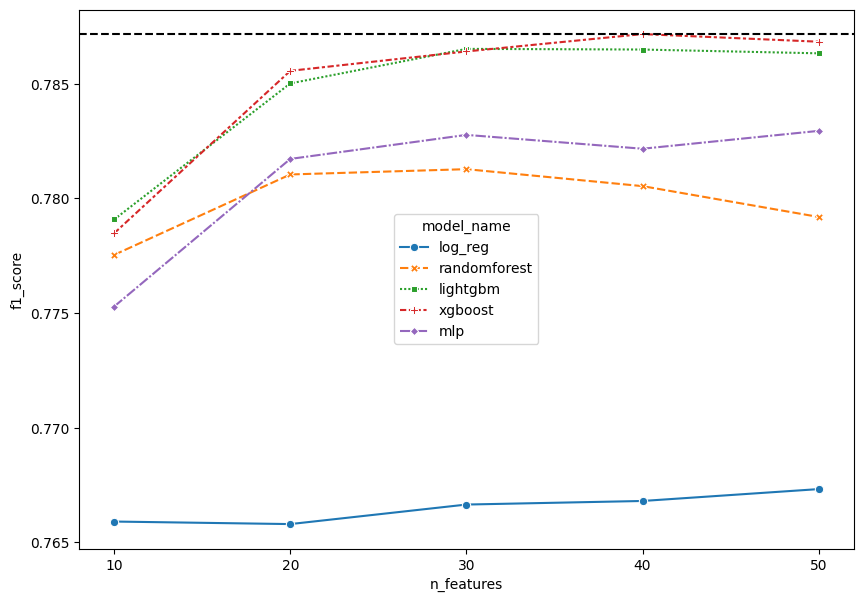

In [46]:
plt.figure(figsize=(10,7))
sns.lineplot(x='n_features', y='f1_score',data=outputs, hue='model_name',style='model_name', markers=True,dashes=True)
plt.axhline(t['f1_score'].max(), linestyle='--',color='black')